In [ ]:
from __future__ import division
import argparse
import numpy as np
import collections
import pandas as pd

In [ ]:
from scipy.special import expit

In [ ]:
'''
__authors__ = ['Wen TIAN','Pierrick ALLEGRE','Joao Gabriel Lopes De Oliveira','Bhanu Prakash Yedla ']
__emails__  = ['wen.tian@student-cs.fr','pierrick.allegre@student-cs.fr','joao-gabriel.lopes@student-cs.fr', 'bhanu-prakash.yedla@student-cs.fr']
'''

"\n__authors__ = ['Wen TIAN','Pierrick ALLEGRE','Joao Gabriel Lopes De Oliveira','Bhanu Prakash Yedla ']\n__emails__  = ['wen.tian@student-cs.fr','pierrick.allegre@student-cs.fr','joao-gabriel.lopes@student-cs.fr', 'bhanu-prakash.yedla@student-cs.fr']\n"

# Training Word2Vec

In [ ]:
def text2sentences(path):
    punctuations = {'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',',
                    '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', 
                    ']', '^', '_', '`', '{', '|', '}', '~',' '}
    
    sentences = []
    with open(path, encoding = 'utf-8') as f:
        for l in f:
            words = [''.join(ch for ch in word if ch not in punctuations) for word in l.lower().split()]
            if len(words) > 1:      # we have removed the sentences that have only one word.
                sentences.append( words )
    return sentences

In [ ]:
def sigmoid(x):
    if x > 5:
        return 1
    elif x < -5:
        return 0
    else:
        return 1/(1+np.exp(-x))

In [ ]:
trainset_path = './news.en-00002-of-00100'


sentences = text2sentences(trainset_path)

In [ ]:
class SkipGram:
    def __init__(self, sentences, nEmbed=300, negativeRate=5, winSize = 5, minCount = 5):
        # Storing parameters as class variables
        self.negativeRate = negativeRate
        self.winSize = winSize
        self.minCount = minCount
        self.lr = 0.001
        self.nEmbed = nEmbed
        
        # Introducing a dictionary to track word counts
        # key: word - value: number of times word shows in training data
        self.word_counts = collections.defaultdict(int)
        
        # Adding an unknown word tag
        # (Used for when calculating similarity on a new dataset)
        self.word_counts['UNK_WORD'] = 0
        
        # Counting words
        for row in sentences:
            for word in row:
                self.word_counts[word] += 1

        # Storing count of unique words
        self.w_count = len(self.word_counts.keys())
        
        # Storing a vocabulary of all words
        self.vocab = list(self.word_counts.keys())

        # Creating dictionaries mapping from index to word and vice versa
        self.w2id = dict((word, i) for i, word in enumerate(self.vocab)) 
        self.id2w = dict((i, word) for i, word in enumerate(self.vocab)) 

        # Shorten the unigram table to fit in your computer's RAM
        simplify_table_ratio = 2
        
        self.unigram_table = np.zeros(max(sum(self.word_counts.values()), 1000) , dtype=np.uint32)

        index_fill = 0 
        for word, counts in self.word_counts.items():
            counts = np.uint32((np.ceil((counts ** (3/4))) + simplify_table_ratio) // simplify_table_ratio)
            for _ in range(counts):
                self.unigram_table[index_fill] = self.w2id[word]
                index_fill += 1

        self.unigram_size = index_fill
        self.unigram_table = self.unigram_table[:index_fill]
        
        # Initialize the W (embedding vectors) and C (context vectors) matrices
        self.W = np.random.randn(self.w_count, nEmbed)
        self.C = np.random.randn(self.w_count, nEmbed)
        
        # Ensuring compatibility with the train function
        self.trainset = sentences
        self.trainWords = 0
        self.accLoss= 0
        self.loss = []

    def sample(self, omit):
        """samples negative words, ommitting those in set omit"""
        
        # Converting from set to list
        omit = list(omit)
        # Extracting the id of the words to omit
        widx=self.id2w.get(omit[0])
        cidx=self.id2w.get(omit[1])
        
        # Extracting random samples from the dataset using the words indexes
        sampled_indexes = self.unigram_table[np.random.randint(0, high=self.unigram_size, size = self.negativeRate)]
        
        # In case an omission was sampled, resample that value
        for i, sampled_idx in enumerate(sampled_indexes):
            while sampled_idx == cidx or sampled_idx == widx:
                sampled_idx = self.unigram_table[np.random.randint(0, high=self.unigram_size, size = self.negativeRate)]
                sampled_indexes[i] = sampled_idx
        
        return sampled_indexes
        
    def train(self):
        self.loss_rec_ = []
        for counter, sentence in enumerate(self.trainset):
            # Small adjustment adding list() to make python 3 compatible
            sentence = list(filter(lambda word: word in self.vocab, sentence))
            
            for wpos, word in enumerate(sentence):
                wIdx = self.w2id[word]
                winsize = np.random.randint(self.winSize) + 1
                start = max(0, wpos - winsize)
                end = min(wpos + winsize + 1, len(sentence))

                for context_word in sentence[start:end]:
                    ctxtId = self.w2id[context_word]
                    if ctxtId == wIdx: continue 
                    negativeIds = self.sample({wIdx, ctxtId})
                    self.trainWord(wIdx, ctxtId, negativeIds)
                    # Calculating loss function
                    self.accLoss += self.loss_function(wIdx, ctxtId, negativeIds)
                    self.trainWords += 1

            if counter % 300 == 0:
                # Changing print structure to f-string to make python 3 compatible
                print(f' > training {counter} of {len(self.trainset)}')
                self.loss.append(self.accLoss / self.trainWords)
                self.trainWords = 0
                self.accLoss = 0.
                print(self.loss[-1])
            self.loss_rec_.append(self.loss[-1])
        return self.loss_rec_

    def trainWord(self, wordId, contextId, negativeIds):
        """ Calculates and updates the W and C matrices """
        # See derivations from https://arxiv.org/pdf/1411.2738.pdf
                        
        W_update = 0 
        W_update -= (sigmoid(np.dot(self.W[wordId,:], self.C[contextId, :])) - 1) * self.C[contextId, :]
        
        for negativeId in negativeIds:
            self.C[contextId, :] -= self.lr * sigmoid(np.dot(self.W[negativeId,:], self.C[contextId, :])) * self.W[wordId, :]
            W_update -= sigmoid(np.dot(self.W[negativeId,:], self.C[contextId, :])) * self.C[contextId, :]
        
        self.W[wordId, :] -= self.lr * W_update
        
        
        
        # get the derivative of the positive part of the likelihood wrt w
        
        #der_log_sigmoid_wrt_w = self.C[contextId, :]/( 1 + np.exp(np.dot(self.W[wordId,:],self.C[contextId,:])))
        #der_neg_sample_wrt_w = sum(-self.C[contextId, :]/(1+ np.exp(np.dot(-self.W[negId,:],self.C[contextId,:]))) for negId in negativeIds)
        
        
        # get the derivative of the positive part of the likelihood wrt y
        #der_log_sigmoid_wrt_c = self.W[wordId, :]/( 1 + np.exp(np.dot(self.W[wordId,:],self.C[contextId,:])))
        #der_neg_sample_wrt_c = sum(-self.W[wordId,:]/(1+ np.exp(np.dot(-self.W[negId,:],self.C[contextId,:]))) for negId in negativeIds)
        #der_neg_sample_wrt_c = 0
        
        #print(f"{der_log_sigmoid_wrt_w} {der_neg_sample_wrt_w} {der_log_sigmoid_wrt_c} {der_neg_sample_wrt_c}")
        # Update the x column of the W matrix
        #self.W[wordId,:] -= self.lr * (der_log_sigmoid_wrt_w + der_neg_sample_wrt_w )
        # Update the y column of the C matrix
        #self.C[contextId,:] -= self.lr * (der_log_sigmoid_wrt_c + der_neg_sample_wrt_c )

    def save(self,path='mymodel.model'):
        """ Saves the model using np.save function. The matrices are saved sequentially as such:
                1. The word_counts is transformed into a nDrive, will send you the links once all is done!
umpy array and saved.
                2. The W matrix is saved
                3. The C matrix is saved
        """
        
        with open(path, 'wb') as f:
            np.save(f, np.array(list(self.word_counts.items())), allow_pickle=False, fix_imports=True)
            np.save(f, self.W, allow_pickle=False, fix_imports=True)
            np.save(f, self.C, allow_pickle=False, fix_imports=True)

    def similarity(self,word1,word2):
        """
        computes similiarity between the two words. unknown words are mapped to one common vector
        :param word1:
        :param word2:
        :return: a float \in [0,1] indicating the similarity (the higher the more similar)
        """
        
        # If the two words are the same, they are absolutely similar
        if word1 == word2:
            print("same word")
            return 1
        
        # Checks if word is in dictionary, if not, uses UNK_WORD tag
        if word1 in self.w2id:
            id1 = self.w2id[word1]
        else:
            id1 = self.w2id['UNK_WORD']
        if word2 in self.w2id:
            id2 = self.w2id[word2]
        else:
            id2 = self.w2id['UNK_WORD']
        
        # If both words are unknown, default to them being completely different (heuristic)
        if id1 == id2:
            print("Unknown word")
            return 0
        
        #embedding = self.W[id1, :]
        
        cos_sim = np.dot(self.W[id1,:], self.W[id2,:])/(np.linalg.norm(self.W[id1,:])*np.linalg.norm(self.W[id2,:]))
        
        if cos_sim > 1:
            cos_sim = 1
        elif cos_sim < -1:
            cos_sim = -1
            
        return (cos_sim + 1)/2
        #return 1 / (1 + np.exp(np.dot(self.W[id1,:], self.C[id2,:])))
   
    def loss_function(self, wordId, contextId, negativeIds):
        """ Returns the loss for the given word, its context and the negative samples"""
        
        l_sum = sigmoid(np.dot( -self.W[wordId, :], self.C[contextId, :] ))
        
        for negativeId in negativeIds:
            l_sum *= 1 - sigmoid(np.dot( -self.W[negativeId, :], self.C[contextId, :] ))
        
    
        #rint(expit(np.dot( self.W[wordId, :], self.C[contextId, :] )), end='\r')
        return l_sum
                           
    @staticmethod
    def load(path):
        """ Loads a new instance of the class from the file created during save()
            It generates a blank SkipGram class and fills it with the data in the saved file
        """
        with open(path, 'rb') as f:
            word_counts_array = np.load(f)
            W = np.load(f)
            C = np.load(f)
         
        loadedModel = SkipGram([])
        
        for word, counts in word_counts_array:
            loadedModel.word_counts[word] = counts
            
        # Storing count of unique words
        loadedModel.w_count = len(loadedModel.word_counts.keys())
        
        # Storing a vocabulary of all words
        loadedModel.vocab = list(loadedModel.word_counts.keys())

        # Creating dictionaries mapping from index to word and vice versa
        loadedModel.w2id = dict((word, i) for i, word in enumerate(loadedModel.vocab)) 
        loadedModel.id2w = dict((i, word) for i, word in enumerate(loadedModel.vocab)) 

        
        loadedModel.W = W
        loadedModel.C = C
        
        return loadedModel
    


# Toy dataset -> Use for testing

In [ ]:
toy_sentences = [["an", "amazing", "apple", "article", "articulated", "android"], ["the", "tired", "tiger", "tisturbs", "the", "timid", "tablet"]]

model = SkipGram(toy_sentences, nEmbed=3)
for i in range(1000):
    model.train()
print(model.W)

print(model.C)

print(model.similarity("an", "amazing"))
print(model.similarity("tired", "tiger"))

print(model.similarity("tiger", "an"))
print(model.similarity("an", "tiger"))




print ("Unknown words test")
print(model.similarity("parser", "amazing"))
print(model.similarity("parser", "yellow"))
print(model.similarity("amzing", "parser"))

 > training 0 of 2
0.012428968728271135
 > training 0 of 2
0.02368082072083945
 > training 0 of 2
0.014054614967399482
 > training 0 of 2
0.015722078815172753
 > training 0 of 2
0.018181132783171277
 > training 0 of 2
0.015331858000717818
 > training 0 of 2
0.012617103746402208
 > training 0 of 2
0.019325728758234694
 > training 0 of 2
0.01666157319669799
 > training 0 of 2
0.011539451401135508
 > training 0 of 2
0.01424650138347291
 > training 0 of 2
0.014672389726479742
 > training 0 of 2
0.01478163343042228
 > training 0 of 2
0.008026374881812374
 > training 0 of 2
0.012457815634297755
 > training 0 of 2
0.0264788988029332
 > training 0 of 2
0.012558230623721984
 > training 0 of 2
0.016132821355710994
 > training 0 of 2
0.008234686402199428
 > training 0 of 2
0.013574901107493827
 > training 0 of 2
0.01692873925990161
 > training 0 of 2
0.011611272510014078
 > training 0 of 2
0.008932528502076414
 > training 0 of 2
0.018118878414144717
 > training 0 of 2
0.012435786625187257
 > trai

 > training 0 of 2
0.01666644741068274
 > training 0 of 2
0.01388969947306677
 > training 0 of 2
0.029988459908281744
 > training 0 of 2
0.012391691873155303
 > training 0 of 2
0.024028122487726067
 > training 0 of 2
0.013279394816960754
 > training 0 of 2
0.014095904359344703
 > training 0 of 2
0.02027580876443785
 > training 0 of 2
0.010800503452327062
 > training 0 of 2
0.02221037739311246
 > training 0 of 2
0.025699677987017968
 > training 0 of 2
0.03813975499395326
 > training 0 of 2
0.011454287021898832
 > training 0 of 2
0.011360936039093595
 > training 0 of 2
0.009421625924124573
 > training 0 of 2
0.01720957977134552
 > training 0 of 2
0.014942548696695155
 > training 0 of 2
0.023105171115555018
 > training 0 of 2
0.016949258649312023
 > training 0 of 2
0.03049188332612725
 > training 0 of 2
0.006254731719124184
 > training 0 of 2
0.021805373408184173
 > training 0 of 2
0.017066465841643303
 > training 0 of 2
0.01819460017347548
 > training 0 of 2
0.013418454253675214
 > train

 > training 0 of 2
0.013523480436188503
 > training 0 of 2
0.022694244194433
 > training 0 of 2
0.011038548880994295
 > training 0 of 2
0.025693885301841756
 > training 0 of 2
0.03840860665309028
 > training 0 of 2
0.020638868198865585
 > training 0 of 2
0.015681085883447406
 > training 0 of 2
0.012314972725418977
 > training 0 of 2
0.02607415557248528
 > training 0 of 2
0.01587429342008579
 > training 0 of 2
0.016523004101048625
 > training 0 of 2
0.010474947408165167
 > training 0 of 2
0.02071470352082525
 > training 0 of 2
0.022802853349301138
 > training 0 of 2
0.012438733865822641
 > training 0 of 2
0.020614475346739117
 > training 0 of 2
0.015523155424632945
 > training 0 of 2
0.010278944438816625
 > training 0 of 2
0.016107514060451585
 > training 0 of 2
0.00953114476934423
 > training 0 of 2
0.02704836181326447
 > training 0 of 2
0.015335031824538617
 > training 0 of 2
0.02989240739002579
 > training 0 of 2
0.01938557591432345
 > training 0 of 2
0.01303252332353675
 > training 

 > training 0 of 2
0.013573265497406926
 > training 0 of 2
0.013245583403371392
 > training 0 of 2
0.02316254057172192
 > training 0 of 2
0.022976072565323816
 > training 0 of 2
0.020963928978502695
 > training 0 of 2
0.020671244934100014
 > training 0 of 2
0.019307204154993794
 > training 0 of 2
0.016477353927460612
 > training 0 of 2
0.004639726995868524
 > training 0 of 2
0.027674595722402627
 > training 0 of 2
0.009633706305229577
 > training 0 of 2
0.023269589681656086
 > training 0 of 2
0.013565908116697221
 > training 0 of 2
0.008110886974246119
 > training 0 of 2
0.015619633924000537
 > training 0 of 2
0.00999393899872953
 > training 0 of 2
0.010376734086040593
 > training 0 of 2
0.024179495302889212
 > training 0 of 2
0.00910428147392882
 > training 0 of 2
0.03410352227884202
 > training 0 of 2
0.015628451672953337
 > training 0 of 2
0.01925965648359057
 > training 0 of 2
0.015679137378664443
 > training 0 of 2
0.009064192950244757
 > training 0 of 2
0.010280502057001959
 > tr

 > training 0 of 2
0.02914258070295552
 > training 0 of 2
0.015955410619296607
 > training 0 of 2
0.020758070183801592
 > training 0 of 2
0.006850386498497252
 > training 0 of 2
0.023682481429861044
 > training 0 of 2
0.02046924487747813
 > training 0 of 2
0.009640906255995438
 > training 0 of 2
0.026690219952778024
 > training 0 of 2
0.013316782229917723
 > training 0 of 2
0.0181885333992873
 > training 0 of 2
0.018100420715715937
 > training 0 of 2
0.014791329385932781
 > training 0 of 2
0.034391530206997326
 > training 0 of 2
0.012991542652157262
 > training 0 of 2
0.018112480277227685
 > training 0 of 2
0.013376171447802112
 > training 0 of 2
0.027417259408508962
 > training 0 of 2
0.013526999500137032
 > training 0 of 2
0.020541434580878305
 > training 0 of 2
0.02377920846110653
 > training 0 of 2
0.024671252603952913
 > training 0 of 2
0.019151190782962957
 > training 0 of 2
0.022004332428120738
 > training 0 of 2
0.014964727544780204
 > training 0 of 2
0.02709281261459799
 > tra

# True dataset

In [ ]:
model = SkipGram(sentences[:5000], winSize = 3)

In [ ]:
train_loss_ = model.train()

 > training 0 of 5000
0.01369405094325184
 > training 300 of 5000
0.014901512004146661
 > training 600 of 5000
0.014894713826914147
 > training 900 of 5000
0.01541942161624279
 > training 1200 of 5000
0.015646874446167355
 > training 1500 of 5000
0.015595199979043746
 > training 1800 of 5000
0.01640101690936631
 > training 2100 of 5000
0.014693374679705119
 > training 2400 of 5000
0.016000673894749788
 > training 2700 of 5000
0.015341494031501063
 > training 3000 of 5000
0.017194094233014882
 > training 3300 of 5000
0.017537598674117517
 > training 3600 of 5000
0.016197745876362423
 > training 3900 of 5000
0.016393879973187326
 > training 4200 of 5000
0.016336065982718258
 > training 4500 of 5000
0.014540762480162292
 > training 4800 of 5000
0.016210261183109077


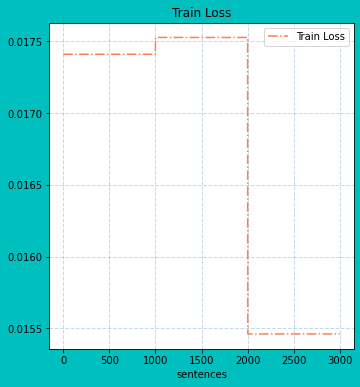

In [ ]:
#train_loss_ = model.train()
import matplotlib.pyplot as plt
# Save performance of the loss
log = pd.DataFrame()
log['train_loss'] = np.array(train_loss_)
log.to_csv('log.csv')

'''Visualize the performance'''
log = pd.read_csv('log.csv') # Load the performance log
plt.figure(figsize=(12,6),facecolor='c')

plt.subplot(121)
plt.title('Train Loss')
plt.xlabel('sentences')
plt.plot(log.train_loss, color='coral', linestyle='-.', label='Train Loss')
plt.legend()
plt.grid(color='steelblue', linestyle='--', linewidth=1.0,alpha=0.3)

In [ ]:
model.save('50k_sentences_XinRong_grad_winSize_3.model')

# Testing on SimLex

In [ ]:
def loadPairs(path):
        data = pd.read_csv(path, delimiter='\t')
        # Inserted SimLex999 column
        data = pd.DataFrame (data, columns = ['word1','word2','SimLex999'])
        pairs = zip(data['word1'],data['word2'],data['SimLex999'])
        return pairs

In [ ]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--text', help='path containing training data', required=True)
    parser.add_argument('--model', help='path to store/read model (when training/testing)', required=True)
    parser.add_argument('--test', help='enters test mode', action='store_true')

    opts = parser.parse_args()

    if not opts.test:
        sentences = text2sentences(opts.text)
        sg = SkipGram(sentences)
        sg.train()
        sg.save(opts.model)

    else:
        pairs = loadPairs(opts.text)

        sg = SkipGram.load(opts.model)
        for a,b,_ in pairs:
            # make sure this does not raise any exception, even if a or b are not in sg.vocab
            print(sg.similarity(a,b))

In [ ]:
model = SkipGram.load('50k_sentences_XinRong_grad_winSize_3.model)


In [ ]:
pairs = loadPairs("SimLex-999/SimLex-999.txt")
l2_loss = []
l1_loss = []
for w1,w2, simi in pairs:
    # make sure this does not raise any exception, even if a or b are not in sg.vocab
    
    # Adjusting cos similarity to [0, 1]
    model_simi = (model.similarity(w1,w2) + 1)/2
    truth_simi = simi/10
    l2_loss.append( (truth_simi - model_simi)**2 )
    l1_loss.append( np.abs(truth_simi - model_simi) )
    #l.append(np.abs(np.round((simi/10)) - model.similarity(w1,w2)))
    print(f"{truth_simi} + {model_simi} + {(truth_simi - model_simi)**2}")

In [ ]:
sum(l2_loss)/len(l2_loss)

In [ ]:
sum(l1_loss) / len(l1_loss)